In [42]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
import os
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=True)
ampl.set_color_cycle("Paper", 6)
import uproot
import glob
import awkward as ak

/home/badea/.conda/envs/hls4ml-tutorial/lib/python3.10/site-packages/atlas_mpl_style/__init__.py:212: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  _warn.warn(


In [84]:
# load the cms dataset
eosdir = '/local/d1/badea/tracker/data/smartpix/parquet/dataset12/unflipped'
truth9 = pd.DataFrame()
for f in os.listdir(eosdir):
    if 'recon' in f:
        continue
    truth9 = pd.concat([truth9,pd.read_parquet(os.path.join(eosdir,f)),])
print(len(truth9))

7999482


In [86]:
# load the root files
files = "/local/d1/badea/tracker/smartpix/simulation/outdir/cmsMatch/4/*.root"
tree = "Delphes"
delphes_track_pt = []
for array in uproot.iterate(f"{files}:{tree}", ["Track.PT"]):
    # each of the following have 100 entries
    delphes_track_pt.append(ak.flatten(array["Track.PT"]))
delphes_track_pt = np.array(np.concatenate(delphes_track_pt))
print(delphes_track_pt.shape)

(6278118,)


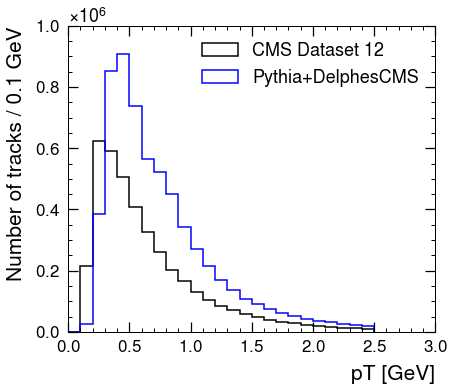

In [89]:
# make plot
fig = plt.figure(figsize=(6, 5))
ax = plt.axes([0.1, 0.1, 0.85, 0.85])

# settings
lw=1.5
rasterized = False
density = False
bins = np.linspace(0,2.5,26)
bw = bins[1]-bins[0]

# draw data
ax.hist(truth9.pt, 
        bins=bins,
        alpha=1.0, 
        lw=lw,
        ls="-",
        histtype="step",
        label="CMS Dataset 12",
        color="black",
        density=density,
        rasterized=rasterized)
# draw simulation
ax.hist(delphes_track_pt, 
        bins=bins,
        alpha=1.0, 
        lw=lw,
        ls="-",
        histtype="step",
        label="Pythia+DelphesCMS",
        color="blue",
        density=density,
        rasterized=rasterized)

# set labels
ax.set_xlabel("pT [GeV]", fontsize=21, labelpad=9, horizontalalignment='right', x=1.0)
ax.set_ylabel(("Density of tracks" if density else "Number of tracks")+f" / {bw} GeV", fontsize=21, labelpad=9, horizontalalignment='right', y=1.0)

# set limits
ax.set_xlim(0, 3)
# ax.set_ylim(0, 2.6)

# tick params
tick_params_major = {"which"     : "major",
                     "length"    : 10,
                     "width"     : 1.25,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 17,
                     "pad"       : 8}
tick_params_minor = {"which"     : "minor",
                     "length"    : 4,
                     "width"     : 1,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 15}

# ax.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(**tick_params_major)
ax.tick_params(**tick_params_minor)
plt.locator_params(axis='y', nbins=8)
plt.locator_params(axis='x', nbins=8)

# save
# plt.yscale("log")
plt.legend()
plt.show()
# outFileName = var+".pdf"
# plt.savefig(outFileName, bbox_inches="tight") # _noFirstLayer